# Sampling from a bivariate Gaussian

In this exercise, we will introduce standard sampling procedure with a simple toy distribution: a bivariate Gaussian!
To this end, we will only use samples from univariate Gaussians.
Note that the method we will look at are not the best one in order to sample from this distribution, our goal is to implement ancestral sampling and MCMC on a simple example that we can easily visualize.

## Preamble

In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import itertools
import random
import math
import time

%matplotlib inline

The following function can be used to plot samples. If you pass two arrays of samples, the first one will be in blue and the second one in red. You can then visualize if your generated samples looks like coming from the same distribution as the target.

Note: this may not be optimal if you have a vision deficiency. Please let me know if this is the case so we can work out a better plotting format.

In [2]:
# samples1-2 shape must be (n samples, 2)
def plot_samples(samples1, samples2=None):
    fig, ax = plt.subplots()

    ax.scatter(samples1[:,0], samples1[:,1], marker="x", color="blue")
    if samples2 is not None:
        ax.scatter(samples2[:,0], samples2[:,1], marker="x", color="red")

The following class implement an univariate Gaussian distribution.
Note that we initialize it with the standard deviation instead of the variance.
We use the numpy function to sample: https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html

In [3]:
class UnivariateGaussian:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def sample(self, n_samples=1):
        return np.random.normal(self.mean, self.std, n_samples)

The bivariate gaussian class takes 5 arguments:

- the mean and standard deviation for the first coordinate;
- the mean and standard deviation for the second coordinate;
- the correlation coefficient.

The sample function can be used to directly generate samples: this is the function we will try to recode using ancestral and MCMC sampling. Here we again use the numpy function as a reference.

For ancestral and Gibbs sampling we will need to sample from the conditional distribution, i.e. $p(x_1 | x_2)$ and $(x_2 | x_1)$. They are univariate Gaussians. The first exercise is too code these two functions:

- x1_cond_x2: conditional distribution $p(x_1 | x_2)$
- x2_cond_x1: conditional distribution $p(x_2 | x_1)$

If you don't know how to compute the mean and standards deviation of these conditional distribution, you can watch the following video: https://www.youtube.com/watch?v=fb8uE4NM2fc

We will also need the marginal distributions $p(x_1)$ and $p(x_2)$. As you can see, they are straighforward to compute. :)

In [4]:
class BivariateGaussian:
    def __init__(self, mean1, std1, mean2, std2, p):
        self.mean1 = mean1
        self.std1 = std1
        self.mean2 = mean2
        self.std2 = std2
        self.p = p
        
    def _get_param_vecs(self):
        mean = np.array([self.mean1, self.mean2])
        cov = np.array(
            [
                [self.std1 ** 2, self.p * self.std1 * self.std2],
                [self.p * self.std1 * self.std2, self.std2 ** 2]
            ]
        )
        
        return mean, cov
    
    def sample(self, n_samples=1):
        mean, cov = self._get_param_vecs()
        return np.random.multivariate_normal(mean, cov, n_samples)
    
    def pdf(self, x):
        mean, cov = self._get_param_vecs()
        return scipy.stats.multivariate_normal.pdf(x, mean=mean, cov=cov)
    
    # Marginal distributions are easy to compute for bivariate Gaussians! :)
    def marginal_x1(self):
        return UnivariateGaussian(self.mean1, self.std1)
    
    def marginal_x2(self):
        return UnivariateGaussian(self.mean2, self.std2)
        
    # should return the distribution p(x_1 | x_2),
    # which is usefull both for ancestral sampling and Gibbs sampling
    
    # We use the formula given by the video
    def x1_cond_x2(self, x2):
        mean=self.mean1+((self.p*self.std1*(x2-self.mean2))/(self.std2))
        std=(1-self.p**2)*self.std1

        return UnivariateGaussian(mean, std)
        
    # should return the distribution p(x_2 | x_1)
    def x2_cond_x1(self, x1):
        mean=self.mean2+((self.p*self.std2*(x1-self.mean1))/(self.std1))
        std=(1-self.p**2)*self.std2

        return UnivariateGaussian(mean, std)

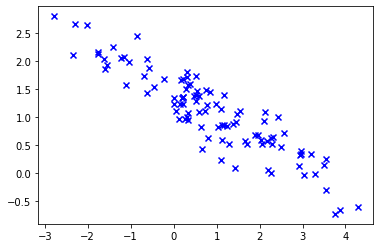

In [5]:
target_bi_gaussian = BivariateGaussian(1, 1.5, 1, 0.7, -0.9)

plot_samples(target_bi_gaussian.sample(100))

# Ancestral sampling

The method consist of sampling from $p(x_1, x_2)$ as follows:

- first sample $x_1$: $x_1 \sim p(x_1)$
- then sample $x_2$: $x_2 \sim p(x_2 | x_1)$

Of course, one can first sample $x_2$ and then $x_1$.

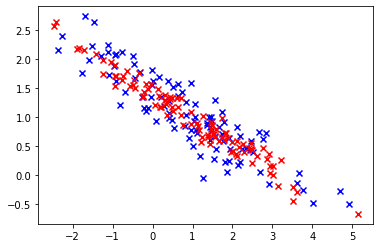

In [6]:
n_samples = 100

# we fix the shape the we can easily concatenate
# the two array before calling the plotting function.
# In the code, use inplace operations to fill these values!
x = np.empty((n_samples, 1))
y = np.empty((n_samples, 1))

x[:, 0] = target_bi_gaussian.marginal_x1().sample(n_samples)
for i in range(n_samples):
    y[i] = target_bi_gaussian.x2_cond_x1(x[i]).sample(1)

samples = np.concatenate([x, y], 1)

# blue points: points sampled via numpy function
# red points: points sampled via ancestral sampling
plot_samples(target_bi_gaussian.sample(100), samples)

# Gibbs sampling

In [10]:
def gibbs_sampling(bivariate_gaussian, n_samples, n_burnin=0, n_skip=0):
    # note that we could initialize randomly instead of 0
    point = np.zeros(2)
    
    # array of samples that we will return
    samples = np.empty((n_samples, 2))
    
    # number of generated samples
    # we keep track of it so its easier to implement
    # burn-in and sample skip.
    n_filled = 0 
    
    # just a "while true" loop
    for i in itertools.count(start=0):
        # in the loop, we must update the variable point following
        # the gibbs sampling rule!
        # TODO...
        #sample first point[0] then point[1]
        uni_dist_0=bivariate_gaussian.x1_cond_x2(point[1])
        uni_dist_1=bivariate_gaussian.x2_cond_x1(point[0])
        
        #Get new coordinates form each uniform distribution and update
        point[0]=uni_dist_0.sample()
        point[1]=uni_dist_1.sample()
            
        # check if we keep this sample or not
        if i >= n_burnin and (i - n_burnin) % (n_skip + 1) == 0:
            samples[n_filled] = point
            n_filled += 1
            
            # break the loop if we sampled the required number of points
            if n_filled == n_samples:
                break

    return samples

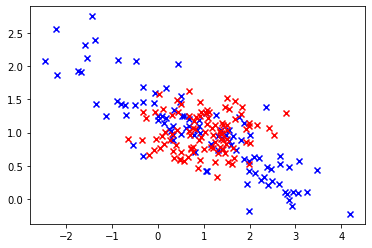

In [12]:
n_samples = 100
n_burnin = 100
n_skip = 100

samples = gibbs_sampling(target_bi_gaussian, n_samples, n_burnin, n_skip)

plot_samples(target_bi_gaussian.sample(n_samples), samples)

# Metropolis sampling

In the Metropolis sampling algorithm, it is useful to check the acceptance rate.
A bad acceptance rate is an indication that we are take "too big steps" in the sampling procedure. If you have a very small acceptance rate (e.g. < 0.3), many of the samples the function return could be equal. The step magnitude depends on the noise_std argument, which is the standard deviant of the Gaussian you use to propose a new point (which can then be either accepted or rejected)

In [18]:
def metropolis_sampling(bivariate_gaussian, n_samples, noise_std = 1, n_burnin=0, n_skip=0):
    point = np.zeros(2)
    samples = np.empty((n_samples, 2))
    
    n_filled = 0
    accept = 0
    reject = 0
    for i in itertools.count(start=0):
        
        # TODO:
        # remember that you must first sample a new point,
        # and then accept or reject it.
        # You need to use both:
        # - np.random.normal
        # - and random.uniform
        # Note that here you don't use the unnormalized probability,
        # just use the PDF!
        #
        # and don't forget to update variables accept and reject
        # to keep track of how many points have been accepted or rejected
        
        #Yo he entendido, candidato está en una gausiana con el punto anterior como media.
        candidate=np.random.normal(point,noise_std)
        
        #Esto es lo que me raya para calcular la accept_prob
        cand=random.uniform(candidate[0],candidate[1])
        po=random.uniform(point[0],point[1])
        
        #En los apuntes tenemos la parte izqda de la super fraccion como la división de las pdfs, creo
        #Y en la derecha, la (proporción) de puntos random entre los puntos en 2D? con la probabilidad marginal claro
        
        left=bivariate_gaussian.pdf(candidate)/bivariate_gaussian.pdf(point)
        right=bivariate_gaussian.x1_cond_x2(cand).sample()/bivariate_gaussian.x2_cond_x1(po).sample()
        
        #Luego esto es seguir las instrucciones, easy.
        
        accept_prob=min(1,left*right)
        
        u=np.random.uniform(0,1)
        
        if(u<accept_prob):
            point=candidate
            accept+=1
        else:
            reject+=1
        
        
        if i >= n_burnin and (i - n_burnin) % (n_skip + 1) == 0:
            samples[n_filled] = point
            n_filled += 1
            if n_filled == n_samples:
                break

    print("Acceptance rate: ", accept / (accept + reject))
    return samples

Acceptance rate:  0.27900990099009904


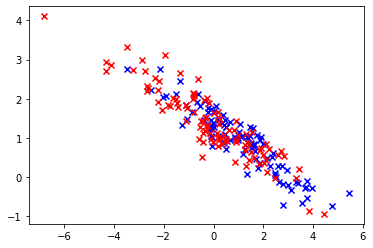

In [19]:
n_samples = 100
n_burnin = 100
n_skip = 100
noise_std = 1

samples = metropolis_sampling(target_bi_gaussian, n_samples, noise_std, n_burnin, n_skip)

plot_samples(target_bi_gaussian.sample(n_samples), samples)